In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import glob


In [2]:
csvs = glob.glob('data/adding_terms/*.csv')
for csv in csvs:
    df = pd.read_csv(csv, index_col=0)
    if 87 in df.num_terms.values:
        print(f'The outlier 87-term model is in {csv}')
data = pd.concat([pd.read_csv(csv, index_col=0) for csv in csvs]).reset_index(drop=True)
data = data[data.num_terms != 87] #There's an outlier prediction on an 87-term model learned for just one cell
info = data.groupby('num_terms').agg({'mse_mo': 'mean', 'mse_ML': 'mean'}).reset_index()

The outlier 87-term model is in data/adding_terms/myo_cell_2.csv


SINDy model captures 77.16 percent of UNet model


Text(0.5, 0.0, 'Learnable Parameters')

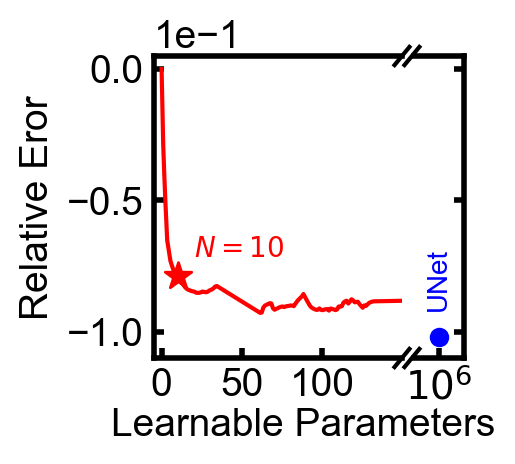

In [4]:
from scipy.interpolate import interp1d
import matplotlib.font_manager
matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.style'] = 'normal'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

def smooth(x, window):
    x = np.pad(x, (window // 2 - 1, window // 2 - 1), mode='edge')
    return np.convolve(x, np.ones(window) / window, mode='valid')

info = info[info.num_terms <= 300]
info['mse_ML'] -= info['mse_mo'].max()
info['mse_mo'] -= info['mse_mo'].max()

x, y = info.num_terms, info.mse_mo

f = interp1d(x, y, fill_value='extrapolate')
xnew = np.arange(0, x.max() + 1)
xnew = np.arange(0, 200)

window = 6
xsmooth = np.pad(smooth(xnew, window),    (1, 0), mode='constant')
ysmooth = np.pad(smooth(f(xnew), window), (1, 0), mode='constant')

f = interp1d(xsmooth, ysmooth)

xx = 10 #Plot at 10 terms
idx = np.argmin(np.abs(xsmooth - xx))

fig = plt.figure(dpi=200, figsize=(2, 2))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 0.2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax1.plot(xsmooth, ysmooth, color='red')
ax1.scatter(xx, f(xx), marker='*', color='red', s=100)
ax1.text(xx+10, f(xx)+1e-2, '$N=10$', transform=ax1.transData, 
         color='red', ha='left', va='center', fontsize=10)
xNN, yNN = 1e6, info.loc[0, 'mse_ML'].mean()

print('SINDy model captures %.2f percent of UNet model' % (100 * f(xx) / yNN))
ax2.plot(xNN, yNN, linestyle='', marker='o', color='blue')
ax2.text(xNN, yNN + 1e-2, 'UNet', transform=ax2.transData, 
         color='blue', ha='center', va='bottom', 
         fontsize=10, rotation=90)
ax1.tick_params(which='both', direction='in', width='2')
ax2.tick_params(which='both', direction='in', width='2')

ax1.ticklabel_format(axis='y', style='sci', scilimits=[-1, 1])

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.tick_params(labelright=False)

ax1.set(xlim=[-5, 150], xticks=[0, 50, 100])
ax2.set(xlim=[990000, 1010000], xticks=[1e6], xticklabels=['$10^6$'])
ax1.set(ylim=[-1.1e-1, 5e-3], yticks=[0, -5e-2, -1e-1])
ax2.patch.set_alpha(0.)

d = .03  # how big to make the diagonal lines in axes coordinates
wspace = 0.08
plt.subplots_adjust(wspace=wspace)
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 + wspace/2. - d, 1 + wspace/2. + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)
ax1.plot((1 + wspace/2. - d, 1 + wspace/2. + d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes

ax1.set_ylabel('Relative Eror')
fig.text(0.5, 0.0, 'Learnable Parameters', ha='center', va='top')
#plt.savefig('Figures/adding_terms_sindy.svg')